# Our scratch notebook for the brain data challenge! :D

### Commentaires pour vous à supprimer dans le notebook final:
C’est un challenge avec pas mal de petit trucs techniques auxquels il vaut mieux faire gaffe.
Au lieu de répéter 3 fois sur messenger les choses (et que ça se perde dans la conv), je préfère tout écrire ici au fur et à mesure (en vrac, des infos pour faire tourner le code/ des remarques.)
Je préfère être explicite, quite à ce que ça soit exhaustif.

Dans le code fourni à utiliser dans notre notebook pour charger le dataloader du lien github du notebook énoncé, il y a l’adresse suivante: '/home/likan_blk/BCI/data_loader' . Or, il semble que je n’y ai pas accès sur zoe, ça me mettait “module introuvable”.
Du coup, à la place, j’ai cloné localement le dataloader depuis github, et utilisé à la place le lien suivant : ‘data_loader’, avec data_loader le folder contenant les fichier .py du lien github pour le dataloader.

Le path_to_data est '/mnt/datasets/eeg'. J’ai laissé en commentaire les anciennes lignes que j’ai modifiées, on pourra toujours y revenir, au cas où.

Il faut télécharger mne avec pip install --user mne , et sans doute ajouter la location de mne au path pour que le dataloader marche (je l'ai ajouté perso, même si je ne sais pas si c'était nécessaire).


J’ai aussi ajouté, au fur et à mesure du notebook plein de petits commentaires (en plus de celui là) pour expliquer les choses. C’est surtout pour vous aider vous, vous devrez supprimer les commentaires dans le presentation notebook bien sûr



## Imports 

In [1]:
import sys
#sys.path.append('/home/likan_blk/BCI/data_loader')  #Path to data_loader code, cloned from github
sys.path.append('data_loader')
from data import DataBuildClassifier

import numpy as np


## Importing the data (with the provided code)

Below, creating the dataloader class, with the help of DataBuildClassifier class. To test the resample parameter more easily, a new function was defined below:

In [2]:
#data_loader = DataBuildClassifier('/home/likan_blk/BCI/NewData') #Path to directory with data (i.e NewData contatins 25/, 26/ ....)
data_loader = DataBuildClassifier('/mnt/datasets/eeg')
#all_subjects = [25, 26,27,28,29,30,32,33,34,35,36,37,38] 
all_subjects = [25, 26] #plus rapide pour le debug, mais à retirer pour décommenter celui au dessus


#Ancienne version
#subjects = data_loader.get_data(all_subjects,shuffle=False, windows=[(0.2,0.5)],baseline_window=(0.2,0.3),resample_to=500)

#Nouvelle version, plus simple pour le hyperparameter tuning:
def createSubjectsWithResample(resample_value):
    return data_loader.get_data(all_subjects,shuffle=False, windows=[(0.2,0.5)],baseline_window=(0.2,0.3),resample_to=resample_value)



And we import the data like below (hyperparameter ***resample_value*** should be between 80Hz and 500Hz):

In [3]:
subjects = createSubjectsWithResample(200)
print(subjects.keys())

dict_keys([25, 26])


### Note : j'ai créé subjects ici pour vous faire la demo, mais en vrai dans le note book final subjects sera sans doute créé en même temps que le hyperparameter tuning, à plusieurs reprise, avec différentes valeurs de resample_value. Je vous laisserai effacer les créations de subjects inutiles dans le notebook (il y en a plusieurs)

## Data exploration

In [4]:
#Example to access a specific subject's data:
X,y = subjects[25]
print(X.shape) #EEG epochs (Trials) x Time x Channels
print(y.shape)
print(X.dtype, y.dtype)

(329, 60, 19)
(329,)
float64 uint8


In [5]:
print(np.unique(y))

[0 1]


## Model creation

**We can create an original pipeline model from scratch as explained, with layer for every step:**

(si on a pas trop la flemme, mais j'ai l'impression que le prof veut plus qu'on démarre du baseline model, en l'améliorant avec les hints de la fin)

---

###  Spatial filter

### Temporal filter

### Classifier

J'ai pas pu accéder aux liens d'INRIA sur la  Rhiemanian geometry :'( 

---

**Or : use and improve the baseline pipeline model provided in the github repo:**

/!\ je ne sais pas si le baseline model inclus déjà un Spatial et temporal filtering, ou si ça remplace juste la partie classifier... à priori ça remplace toute la pipeline, mais c'est à vérifier.

## Baseline model creation 

J'ai ajouté les documents "model_torch.py" et "utils.py" du dossier src du lien github fourni pour le baseline model(data.py est déjà dans le dossier data_loader).
J'ai adapté leur "solution notebook" à notre notebook, sur cloud platform.

C'est bizarre car il y a un projet github à part pour le data loader, mais une copie du seul  fichier utilisé, data.py, dans le src du github du baseline model. Dans le doute, j'ai gardé le dataloader du repo github sur le dataloader, importé dans le directory **data_loader** relativement à notre notebook, pour entraînner le model suivant. 
Mais, peut être que dans le futur on pourra juste se contenter de data.py que l'on pourra mettre dans **baseline_src**, mettre tous les fichiers source au même endroit, et supprimmer le directory **data_loader**.

In [6]:
#Il y avait ça dans le notebook de demo du baseline model, mais je ne sais pas à  quoi ça sert :'(
%load_ext autoreload
%autoreload 2

In [7]:
import os
from sklearn.model_selection import train_test_split
from baseline_src.utils import single_auc_loging
from baseline_src.utils import prepare_dirs,write_results_table, separte_last_block
from baseline_src.model_torch import train_model_eegnet
import shutil
from sklearn.model_selection import StratifiedKFold
import codecs

In [8]:
experiment_res_dir = './res/' #Path to save results and training|testing statistics

Les hyperparamètres du notebook demo du github(on pourra bien sûr les changer si on veut)
(et faire un peu de hyperparameter tuning, à partir de ces valeurs)

In [9]:
params = {'resample_to': 369,
                 'D': 3,
                 'F1': 12,
                 'dropoutRate1': 0.52,
                 'dropoutRate2': 0.36,
                 'lr': 0.00066,
                 'norm_rate': 0.275
                 }

Il faudra effacer la première instance de "subjects" que j'avais définie plus haut, pour la data visualisation (et réorganiser bien le notebook).
Il faudra aussi effacer celle là (je l'ai mise pour vous faire la démo)

In [10]:
subjects = createSubjectsWithResample(params['resample_to'])

The crossvalidation function imported from the github notebook.
Important: we can see that 20% of the data was set aside for testing , with test_on_last_block = True. It will be important parameters for the hyperparameter tuning step, as our choice for the hyperparameters should not be influenced by the test set.

In [11]:
def cv_per_subj_test(x,y,params,path_to_subj, test_on_last_block=False, plot_fold_history=False):
    model_path = os.path.join(path_to_subj,'checkpoints')
    best_val_epochs = []
    best_val_aucs = []
    folds = 4  # To preserve split as 0.6 0.2 0.2
    if test_on_last_block:
        x_tr,y_tr,x_tst,y_tst = separte_last_block(x,y,test_size=0.2)

    cv = StratifiedKFold(n_splits=folds, shuffle=True)
    cv_splits = list(cv.split(x_tr, y_tr))
    for fold, (train_idx, val_idx) in enumerate(cv_splits):
        fold_model_path = os.path.join(model_path, '%d' % fold)
        os.makedirs(fold_model_path)
        x_tr_fold, y_tr_fold = x_tr[train_idx], y_tr[train_idx]
        x_val_fold, y_val_fold = x_tr[val_idx], y_tr[val_idx]
        val_history, fold_model = train_model_eegnet(x_tr_fold,y_tr_fold,params,(x_val_fold,y_val_fold),epochs=200,
                                                     batch_size=32, shuffle=True,
                                                     model_path=os.path.join(fold_model_path,'model{}'.format(fold)))
        best_val_epochs.append(np.argmax(val_history['val_auc']) + 1)  # epochs count from 1 (not from 0)
        best_val_aucs.append(np.max(val_history['val_auc']))
        if plot_fold_history:
            single_auc_loging(val_history, 'fold %d' % fold, fold_model_path)

    if test_on_last_block:
        test_history, final_model = train_model_eegnet(x_tr, y_tr, params, epochs=int(np.mean(best_val_epochs)),
                                                       validation_data=(x_tst, y_tst), batch_size=32, shuffle=True,
                                                       model_path=os.path.join(path_to_subj,'naive_model'))

    single_auc_loging(test_history, 'test_history', path_to_save=path_to_subj)
    with codecs.open('%s/res.txt' % path_to_subj, 'w', encoding='utf8') as f:
        f.write(u'Val auc %.02f±%.02f\n' % (np.mean(best_val_aucs),np.std(best_val_aucs)))
        f.write('Test auc naive %.02f\n' % (test_history['val_auc'][-1]))

    return {'val_auc':test_history['val_auc'][-1]}, final_model

And finally, training the model with the provided functions:

#### /!\ J'avais eu un bug "torch.nn module has no  attribute Flatten".
J'ai résolu  le problème en upgradant la version de torch sur cloud platform, avec la commande **pip install --upgrade --user torch torchvision**



En dessous le template fourni dans le github pour entraîner le model (attention à ne pas saturer le notebook de prints si vous n'avez pas mis en commentaires les prints dans train_model_eegnet)

In [12]:
#experiment_res_dir = './res/'
#subjs_test_stats = {}
#for train_subject in all_subjects:
#    path_to_subj = prepare_dirs(experiment_res_dir, train_subject)
#    x = subjects[train_subject][0]
#    x = x.transpose(0, 2, 1)[:, np.newaxis, :, :]
#    y=subjects[train_subject][1]
#    test_stats, model = cv_per_subj_test(x, y, params, path_to_subj,test_on_last_block=True, plot_fold_history=True)
#    subjs_test_stats[train_subject] = test_stats

J'en ai fait une fonction, plus facile à recycler pour le hyperparameter tuning.

### Note : 
Perso j'ai mis en commentaire les lignes qui faisaient pleins de prints de la train et val accuracy à chaque étape dans  la fonction **train_model_eegnet** dans model_torch.py, et j'ai importé tqdm avec **pip install --user tqdm** pour avoir tqdm, car c'était assez pratique pour run le code en dessous (plus que de faire des prints de toutes les étapes).

Mais si vous ne voulez pas utiliser tqdm, supprimez le de mon code, aucun soucis.
Et si vous voulez tous les prints, laissez les 2 lignes de prints de train_model_eegnet non commentées.
Par contre, les prints + tqdm ça risque d'être assez moche 

In [13]:
from tqdm import * #ça permet d'avoir une barre de chargement. 
#Remplacez for train_subject in tqdm(all_subjects) par for train_subject in all_subjects
#Retirez tqdm et mettez plot_fold_history=True en paramètre si vous voulez plus de détails 
#en faisant des prints à chaque fois de la train/val loss . Mais le notebook sera moins lisible

def train(subjects, subjs_test_stats, test_on_last_block): #subjects est un dataset chargé comme précédement. 
    experiment_res_dir = './res/'
    for train_subject in tqdm(all_subjects): ##Remplacez  par for train_subject in all_subjects si vous n'utilisez pas tqdm
        path_to_subj = prepare_dirs(experiment_res_dir, train_subject)
        x = subjects[train_subject][0]
        x = x.transpose(0, 2, 1)[:, np.newaxis, :, :]
        y=subjects[train_subject][1]
        test_stats, model = cv_per_subj_test(x, y, params, path_to_subj,test_on_last_block=test_on_last_block, plot_fold_history=True)
        subjs_test_stats[train_subject] = test_stats

Le code ci dessous est juste à titre de démo pour vous.
En effet, le vrai entraînnement se fera plus tard, après le hyperparameter tuning.

perso j'ai eu un warning comme quoi pickle ne serait plus un support possible dans le futur proche, dans la version 1.5, mais ça n'a pas gêné l'exécution de la cellule.

In [14]:
#Cell à effacer dans le notebook final, une fois que tout le monde a compris comment ça marche
subjs_test_stats = {}
train(subjects, subjs_test_stats, test_on_last_block=True)

  0%|          | 0/2 [00:00<?, ?it/s]/mnt/workspace/.local/lib/python3.5/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
100%|██████████| 2/2 [05:33<00:00, 166.88s/it]


This piece will save general information about training in file res.txt contating validating, test naive and test ensamble AUCS for each subject and mean AUC for all subjects

In [15]:
write_results_table(subjs_test_stats, path_to_exp=experiment_res_dir)

We can access the results of the model's performances in res/res.txt, that was just created.
Especially, we can access the mean of the model's AUC on the validation set, among all subjects.
A model was indeed created for each subject.

In [16]:
! cat res/res.txt

subj val_auc
25:0.51
26:0.65
MEAN:0.58��0.07

In [17]:
#Les manières plus simples/classiques d'ouvrir le fichier ne marchait pas, ça faisait des problèmes d'encodage, du coup j'ai utilisé io
import io
with io.open("res/res.txt", "r", encoding="utf-8") as my_file:
     results = my_file.read() 

print(results)

subj val_auc
25:0.51
26:0.65
MEAN:0.58±0.07


In [18]:
import re

In [19]:
#Si vous trouvez une manière plus évidente que du regex pour récupérer les résultats, pas de soucis
#N'hésitez pas à faire des tests pour vérifier que ça prends bien le bon résultat à chaque fois;
#que le regex n'est pas faux
model_val_AUC_MEAN = float(re.findall("MEAN:.*±", results)[0][5:-1])
model_val_AUC_var = float(re.findall("±.*", results)[0][1:])
print(model_val_AUC_MEAN)
print(model_val_AUC_var)

0.58
0.07


Accessing those values will be usefull for the hyperparameter tuning phase 

## Hyperparameter tuning

J'ai commencé une approche de grid search.
Pour faciliter le hyperparameter tuning, j'ai créé une fonction tout en un qui :
- crée un dataset avec les paramètres voulus 
- l'entraîne
- récolte le mean AUC de res.txt
- retourne les paramètres/valeur de AUC

Comme dit dans l'énoncé, "However, **the hyperparameters of your pipeline should be the same for all subjects**", donc la selection par le mean est un choix raisonnable. Et j'ai l'impression que le code basline entraîne bien un modèle différent pour chaque subject avant de faire le mean des AUCs, au lieu d'entraînner un modèle sur tous les subjects et faire le mean.

## /!\ ils disent aussi "Do not use the test set for hyperparameter tuning. You should use your training data (the first 80% EEG epochs) and partition it to carve out a validation set, to be used for hyperparameter tuning."
Or, dans leur code fourni, je pense que  **test_on_last_block** doit être mis à True pour séparer le test set.
J'ai l'impression que la Mean value du AUC que je récupère dans res.txt est indépendante du test set quand je mets
test_on_last_block = true dans la fonction train que j'ai créée, mais c'est pas sûr ...


De plus, j'ai commencé une approche grid search, mais incomplète (juste resample pour le moment).
Il faudra adapter la fonction pour que ça fasse une grid search sur les autres hyperparamètres aussi.
Mais je pense que l'exectution risque d'être très longue, surtout quand on utilisera tous les sujets au lieu de seulement 2.

Vous pouvez tenter aussi  une des autres méthodes dont ils parlaient si vous le voulez, genre Optuna.
ça a de fortes chances d'être plus rapide. Après, c'est pas obligé non plus, ça dépends de votre temps (on peut toujours raffiner et faire mieux bien sûr).

This function below, alltogether with the previously defined functions, helps us doing some grid search on the hyperparameter resample. 

In [20]:
def tuneResampleValue(resample_values_list): 
    mean_AUCs = {}
    var_AUCs = {}
    for resample_val in resample_values_list:
        subjects = createSubjectsWithResample(resample_val)
        subjs_test_stats = {}
        train(subjects, subjs_test_stats, test_on_last_block=True)
        write_results_table(subjs_test_stats, path_to_exp=experiment_res_dir)
        with io.open("res/res.txt", "r", encoding="utf-8") as my_file:
            results = my_file.read() 
        model_val_AUC_MEAN = float(re.findall("MEAN:.*±", results)[0][5:-1])
        model_val_AUC_var = float(re.findall("±.*", results)[0][1:])
        mean_AUCs[str(resample_val)] = model_val_AUC_MEAN
        var_AUCs[str(resample_val)] = model_val_AUC_var
    return mean_AUCs, var_AUCs


Testing a grid search:

In [21]:
import time

In [22]:
#vous pourrez changer la resample_values_list
start = time.time()
resample_values_list = [params['resample_to']-1,params['resample_to'],params['resample_to']+1]
mean_AUCs, var_AUCs = tuneResampleValue(resample_values_list)
end  = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Training time :")
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


  0%|          | 0/2 [00:00<?, ?it/s]/mnt/workspace/.local/lib/python3.5/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
100%|██████████| 2/2 [05:00<00:00, 150.21s/it]

Training time :
00:17:28.68


In [23]:
print(mean_AUCs)

{'368': 0.6, '369': 0.56, '370': 0.52}


In [24]:
print(var_AUCs)

{'368': 0.06, '369': 0.05, '370': 0.06}


Mon code a l'air de marcher, mais la grid search est assez lente... tout ce temps pour seulement 1 hyperparamètre, 3 valeurs possibles, 2 subjects... 
Après, peut être que même les autres méthodes dont parlait le prof sont lentes ceci dit...

## Training the model with the proper hyper parameters

With the hyperparameter tuning above (grid  search ou autre), we can create the real model:

In [25]:
best_resample_value = 370 #best value in the mean_AUCs dict (with only 2 subjects)
subjects = createSubjectsWithResample(best_resample_value)
subjs_test_stats = {}
train(subjects, subjs_test_stats, test_on_last_block=True)


  0%|          | 0/2 [00:00<?, ?it/s]/mnt/workspace/.local/lib/python3.5/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
100%|██████████| 2/2 [03:53<00:00, 116.71s/it]


In [26]:
write_results_table(subjs_test_stats, path_to_exp=experiment_res_dir)
with io.open("res/res.txt", "r", encoding="utf-8") as my_file:
    results = my_file.read() 
model_val_AUC_MEAN = re.findall("MEAN:.*±", results)[0][5:-1]
model_val_AUC_var = re.findall("±.*", results)[0][1:]
print("AUC mean: "+model_val_AUC_MEAN+", AUC var: "+model_val_AUC_var)

AUC mean: 0.48, AUC var: 0.10


## Model explanation (optional)

The models previously created are in res folder.  Each model (for each subject) is in the "naive_model" folder of each subject.
We can have a look at them.

We will load the model and study with t-sne the repartion of the last dense layer.

J'ai commencé à faire un truc pour charger le modèle entraînné dans le notebook, pour accèder à la dernière flatten layer (étape juste avant la répartition par classe), afin d'appliquer du t-sne.
Vous pouvez bien sûr changer/améliorer/supprimer. Mais, si vous voulez faire du t-sne, le code que j'ai fait peut vous aider.

In [27]:
import torch

**1) import model state dict from the file**

In [31]:
PATH = 'res/25/naive_model'
model_25_state_dict = torch.load(PATH)

In [32]:
#print(model_25) #montre tous les weights- il y en a beaucoup 
print(len(model_25_state_dict))
print(model_25_state_dict.keys())

16
odict_keys(['conv1.weight', 'batchnorm1.weight', 'batchnorm1.bias', 'batchnorm1.running_mean', 'batchnorm1.running_var', 'batchnorm1.num_batches_tracked', 'depthwise1.weight', 'batchnorm2.weight', 'batchnorm2.bias', 'batchnorm2.running_mean', 'batchnorm2.running_var', 'batchnorm2.num_batches_tracked', 'separable_block2.depthwise.weight', 'separable_block2.pointwise.weight', 'dense.weight', 'dense.bias'])


**2) Import the data on which we will do visualisation**

In [35]:
#the user corresponding to the loaded model
X,y = subjects[25]
print(X.shape) #EEG epochs (Trials) x Time x Channels
print(y.shape)
print(X.dtype, y.dtype)

(329, 111, 19)
(329,)
float64 uint8


In [37]:
#/!\ reshape data is necessary to feed the model (cf. cv_per_subj_test and train functions )
x = X.transpose(0, 2, 1)[:, np.newaxis, :, :]
print(x.shape) #(trials, kernels, channels, samples)
print(y.shape)

(329, 1, 19, 111)
(329,)


**3) Import a model, and load the state_dict trained weights in the model**

In [41]:
from baseline_src.model_torch import EEGNet_experimental

In [44]:
#'''Data shape = (trials, kernels, channels, samples), which for the
#        input layer, will be (trials, 1, channels, samples).'''

#Init the model 

kernLength1 = params.get('kernLength1',64)
kernLength2 = params.get('kernLength2',16)
F2 = params.get('F2',params['F1']*params['D'])
    
model_25 = EEGNet_experimental(nb_classes=2, Chans=x.shape[2], Samples=x.shape[3],
                               dropoutRates=(params['dropoutRate1'], params['dropoutRate1']),
                               kernLength1=kernLength1, kernLength2=kernLength2, poolKern1=4,
                               poolKern2=8,
                               F1=params['F1'],
                               D=params['D'], F2=F2)

# using gpu if possible (as we are not going to train anymore, but just predict, not very important)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_25.to(device)

EEGNet_experimental(
  (conv1): Conv2d(1, 12, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
  (batchnorm1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (depthwise1): Conv2d(12, 36, kernel_size=(19, 1), stride=(1, 1), groups=12, bias=False)
  (batchnorm2): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_block1): ELU(alpha=1.0)
  (avg_pool_block1): AdaptiveAvgPool2d(output_size=(1, 28))
  (dropout_block1): Dropout(p=0.52, inplace=False)
  (separable_block2): deepwise_separable_conv(
    (depthwise): Conv2d(36, 36, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=36, bias=False)
    (pointwise): Conv2d(36, 36, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (activation_block2): ELU(alpha=1.0)
  (avg_pool_block2): AdaptiveAvgPool2d(output_size=(1, 7))
  (dropout_block2): Dropout(p=0.52, inplace=False)
  (flatten): Flatten()
  (dense): Linear(in_features=252, out_features=2,

In [47]:
model_25.load_state_dict(model_25_state_dict) #this way, we can use the pretrained weights in our model

<All keys matched successfully>

**4) Feeding the model to fetch the features before the last layer/classifier**

Dans le modèle, la prédiction est séparé en 2 fonctions : forward_features, pour avoir les features sur lesquelles seront appliquées la dernière dense layer, et forward, qui appelle forward_features, puis applique la dernière dense layer. C'est assez pratique du coup de récupérer les features sur lesquelles on veut appliquer t-sne

In [50]:
x_tensor = torch.from_numpy(x).float()
features,_ = model_25.forward_features(x_tensor)

In [54]:
flatten_feats = model_25.flatten(features).detach().numpy() #on flatten quand même, mais on applique pas la dense layer qui output la classe
print(flatten_feats.shape)

(329, 252)


**5) Finally, applying t-SNE with the fetched flattened features and y**

In [55]:
print(flatten_feats.shape, y.shape)

(329, 252) (329,)


In [56]:
from sklearn.manifold import TSNE

In [58]:
X_embedded = TSNE(n_components=2).fit_transform(flatten_feats,y)
print(X_embedded.shape)

(329, 2)


In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline #ça ne s'affichait pas si je ne mettait pas ça.

In [81]:
plt.get_backend() 

'module://ipykernel.pylab.backend_inline'

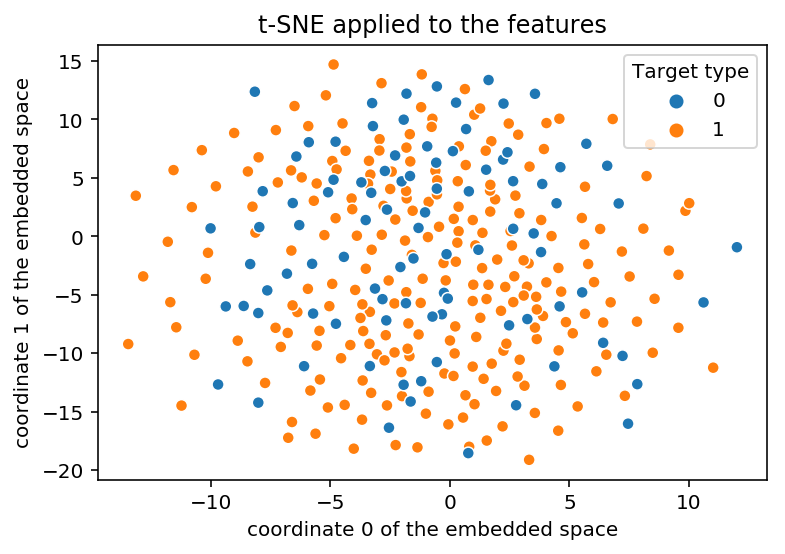

In [87]:
sns.scatterplot(x=X_embedded.T[0], y=X_embedded.T[1], hue=y)
plt.title("t-SNE applied to the features")
plt.xlabel("coordinate 0 of the embedded space")
plt.ylabel("coordinate 1 of the embedded space")
plt.legend(title="Target type")

It unfortunately seems also very noisy... the model seems to have difficulties to "separate" the target and non target inputs.

/!\ Même si le modèle est à priori naif donc possiblement "noisy", et que des PCA préliminaires à une t-sne directement sur les flattened-features peuvent aider, n'hésitez pas à revoir mon code, j'ai peu être fait un truc très bête qui expliquerai ce graphe très "noisy" :'(

## Extensions and hints (optional)

Si vous êtes des pros de Torch, vous pouvez faire des tests et changer/ajouter des layers de model_torch si vous voulez